# Variational Autoencoder 

<center><img src="https://drive.google.com/uc?id=1TYKx4NcNgeoILad7bdjPb59jwQXxS993 " width="80%" height=""></center> 
 
  [출처 : https://www.slideshare.net/NaverEngineering/ss-96581209]
 
 


## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)
from tensorflow.examples.tutorials.mnist import input_data

## MNIST 데이터 세트 로드

In [0]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## VAE 모델 

   
**손실 함수 및 옵티 마이저 정의** \

VAE는 Log Likelihood에 대한 ELBO를 극대화 함으로써 훈련함 :

\

<center><img src="https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg" width ="90%"></center>

[출처 : https://www.slideshare.net/NaverEngineering/ss-96581209]


In [0]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
                self.network_architecture = network_architecture
        # 파라미터 정의하기
        elf.transfer_fct = transfer_fct #활성화 함수(softplus)
        self.learning_rate = learning_rate 
        self.batch_size = batch_size
        
        # Placeholder 정의하기
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        
        # Define loss function based variational upper-bound and corresponding optimizer
        self._create_loss_optimizer()
        
        # 변수 초기화하기
        init = tf.global_variables_initializer()

        # 세션 시작하기
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Recognition network를 사용하여 잠재 공간에서의 가우스 분포의 mu와 (로그) sigma를 결정
        # Encoder = Recognition network
        self.z_mean, self.z_log_sigma = self._encoder_network(network_weights["weights_encoder"], network_weights["biases_encoder"])

        # 가우시안 분포에서 Z를 샘플링
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        
        # Latent variable z 선언 (= 𝜇 + 𝜎 * 𝜀)
        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma)), eps))

        # 제너레이터를 사용하여 재구성된 데이터의 Bernouli 분포 평균을 결정
        self.x_reconstr_mean = self._decoder_network(network_weights["weights_decoder"],network_weights["biases_decoder"])
            
    #인코더 디코더의 가중치를 초기화 하는 함수
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
    
        all_weights = dict()
        all_weights['weights_encoder'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        
        all_weights['biases_encoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        all_weights['weights_decoder'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        
        all_weights['biases_decoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        
        return all_weights
   

    def _encoder_network(self, weights, biases):
        # Q(z|X) -- encoder 
        #입력을 정규분포의 잠재공간에 매핑하는 확률론적 인코더네트워크를 생성한다. 
        
        #2개 fc층을 생성
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        #2번째 층의 출력을 z_mean(평균)와 z_log_sigma(표준편차)에 연결
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean']) 
        z_log_sigma = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        return (z_mean, z_log_sigma)

    def _decoder_network(self, weights, biases):
        #Bernouli분포에 잠재공간을 매핑하는 확률론적 디코더네트워크를 생성한다.
        
        #2개 fc층을 생성
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),biases['b2']))
        
        #디코더의 두번째 층을 연결해 재복원된 데이터 분포의 평균을 출력함
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1_The reconstruction loss 
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),1)
        # 2_Latent loss is Kullback Leibler Loss
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma - tf.square(self.z_mean) - tf.exp(self.z_log_sigma), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss) # average over batch
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def fit(self, X):
        """Train model based on mini-batch of input data.         Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        # 잠재적 공간에 데이터를 매핑하여 변환한다.
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        #잠재된 공간에서 샘플링하여 데이터를 생성한다. 
        #z_mu가 None이 아닌 경우, 잠재된 공간의 이 점에 대한 데이터가 생성된다. 그렇지 않으면, z_mu는 잠재된 공간에 이전부터 그려진다.
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        # 주어진 데이터를 복원하기위해 VAE를 사용한다.
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x: X})

In [0]:
# Xavier Initialization : weight 초기화 방법 중 하나로 표준 정규 분포를 입력 개수의 표준 편차로 나눈다.
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

## Trainning



### 미니 배치를 사용하여 VAE Train함수 정의

In [0]:
def train(network_architecture, learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture,learning_rate=learning_rate,batch_size=batch_size)
    # 훈련 주기
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # epoch당 로그 표시
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

### Reconstruction 품질 설명(z_space=20)

이제 네트워크 토폴로지를 지정하기만 하면 MNIST에서 VAE를 학습할 수 있다. \
20차원의 Latent space를 가진 VAE를 훈련시켜 확인한다.

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space
vae = train(network_architecture, training_epochs=75)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 175.561882602
Epoch: 0006 cost= 108.854022813
Epoch: 0011 cost= 103.860313957
Epoch: 0016 cost= 101.622550201
Epoch: 0021 cost= 100.285562744
Epoch: 0026 cost= 99.336462361
Epoch: 0031 cost= 98.533894431
Epoch: 0036 cost= 97.872305437
Epoch: 0041 cost= 97.325135332
Epoch: 0046 cost= 96.909392062
Epoch: 0051 cost= 96.530577337
Epoch: 0056 cost= 96.154611733
Epoch: 0061 cost= 95.826848089
Epoch: 0066 cost= 95.494507627
Epoch: 0071 cost= 95.275210779


## 결과
 우리는 몇가지 테스트 입력을 샘플링하고 VAE가 그것을 얼마나 잘 재구성 할 수 있는지 볼 수 있다.

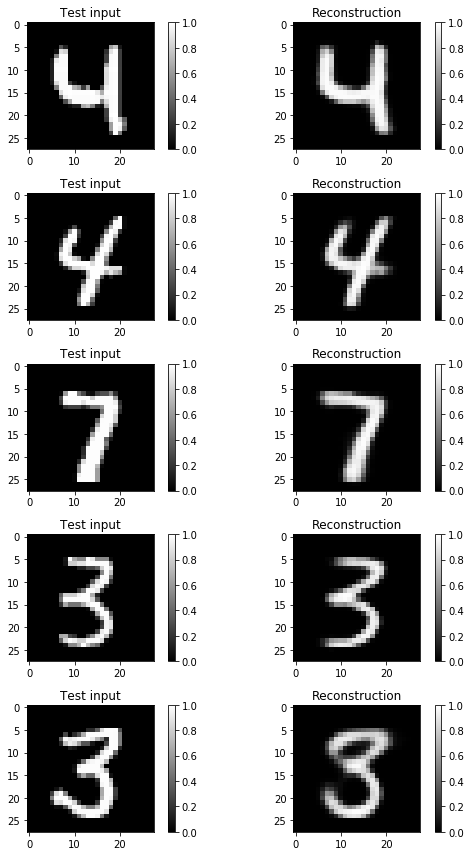

In [0]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Latent Space 확인하기 
2차원 Latent space를 가진 VAE를 훈련시키고, 어떻게 인코더(the recognition network)가 labeled input의 일부를 Encode하는지 T-SNE 그래프로 보여준다.

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 191.332354598
Epoch: 0006 cost= 153.939755388
Epoch: 0011 cost= 149.068145114
Epoch: 0016 cost= 146.871608221
Epoch: 0021 cost= 145.135885648
Epoch: 0026 cost= 144.099623469
Epoch: 0031 cost= 143.223034557
Epoch: 0036 cost= 142.197442710
Epoch: 0041 cost= 142.046196747
Epoch: 0046 cost= 141.378478837
Epoch: 0051 cost= 140.850446555
Epoch: 0056 cost= 140.610103968
Epoch: 0061 cost= 140.220668141
Epoch: 0066 cost= 139.761031716
Epoch: 0071 cost= 139.753281652


### T-SNE

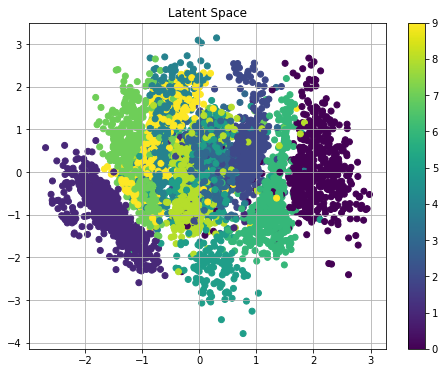

In [0]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.title("Latent Space")
plt.grid()

### 학습된 MNIST의 Manifold
Latent Space에 대해 볼 수 있는 또 다른 방법은 발생된 Latent Space 위치에 재구성된 입력을 표시하기 위해 디코더(Generator Network)를 사용하는 것이다. 

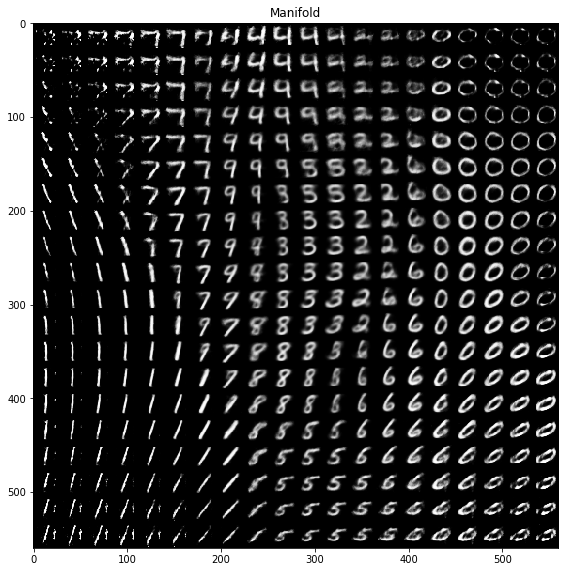

In [0]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold")
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()